In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
import string
import json
# from gensim.models import KeyedVectors
# import numpy as np
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score   # evaluation
from sklearn.metrics import classification_report, cohen_kappa_score, confusion_matrix

import matplotlib.pyplot as plt
import re
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import StratifiedKFold #交叉验证
from sklearn.model_selection import GridSearchCV #网格搜索

import matplotlib
from sklearn.decomposition import PCA


In [61]:
from matplotlib import font_manager as fm

In [2]:
dataset = pd.read_csv("train.csv")

In [3]:
sample = dataset.sample(frac=0.2,random_state = 100) #261224 rows

In [7]:
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

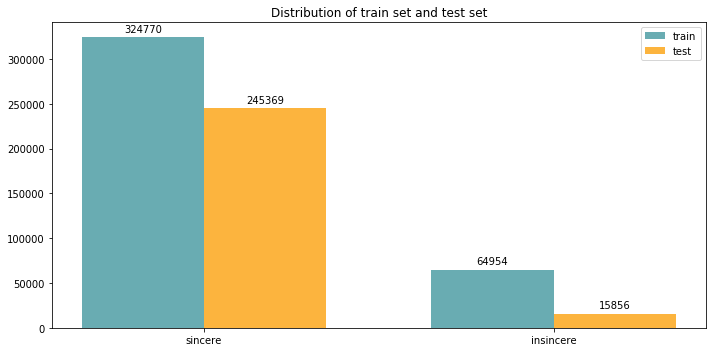

In [30]:
# train test target value
train_set.groupby('target').count()
labels = ['sincere', 'insincere']
train = sample_train_set.target.value_counts() #[20, 34, 30, 35, 27]
test = test_set.target.value_counts()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width/2, train, width, label='train', color='#69acb2')
rects2 = ax.bar(x + width/2, test, width, label='test', color='#fcb43e')

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('')
ax.set_title('Distribution of train set and test set')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

# plt.show()
plt.savefig('train_test_dis.png')
print("=======")

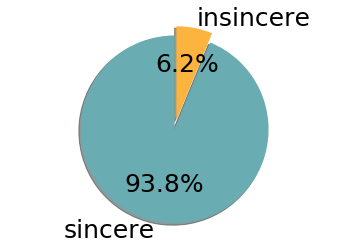

In [67]:
# pie chart show insincere and sincre 

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['sincere', 'insincere']
sizes = dataset.target.value_counts()
# sizes = sample_train_set.target.value_counts()
explode = (0, 0.1,)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=['#69acb2','#fcb43e'], textprops={'fontsize': 25})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.



plt.savefig('train_insin.png')

# plt.show()


In [27]:
def under_sampling(df,percent=1):
    majority = df[df['target'] == 0]  
    minority = df[df['target'] == 1]     
    lower_data = majority.sample(n=int(percent*len(minority)),replace=False,random_state=890,axis=0)   
    return (pd.concat([lower_data,minority]))

In [28]:
sample_train_set = under_sampling(train_set, percent=5)

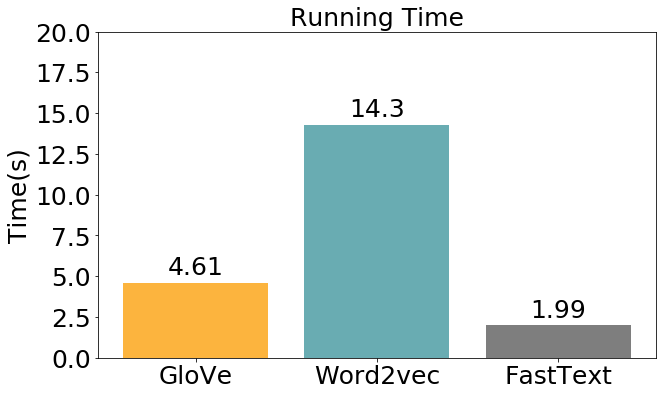

In [59]:
# word coverage
labels = ['GloVe', 'Word2vec', 'FastText']
# train = [64.96, 45.24,53.48]
train = [4.61, 14.3, 1.99]
fs = 25

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,6))
# rects1 = ax.bar(labels,train)
rects1 = ax.bar(labels, train, color=['#fcb43e','#69acb2','#7E7E7E'])
# rects2 = ax.bar(x + width/2, test, width, label='test', color='#fcb43e')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time(s)', fontsize=fs)
# ax.set_ylabel('Embedding Words(%)', fontsize=fs)
ax.set_title('Running Time', fontsize=fs)
ax.set_xticks(labels)
ax.set_xticklabels(labels)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
# ax.legend()
plt.ylim(0,20)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=fs
                   )


autolabel(rects1)
# autolabel(rects2)

# fig.tight_layout()

# plt.show()
plt.savefig('run_time.png')


In [3]:
train_output = pd.read_csv('train_output.csv')

In [5]:
train_output.columns

Index(['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '294', '295', '296', '297', '298', '299', '300', '301', '302',
       'target'],
      dtype='object', length=305)

In [18]:
train_output.loc[train_output['300']>0.2]["300"] = 0.2


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


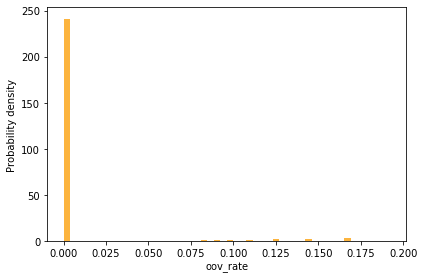

In [19]:
x = train_output[train_output['300']<0.2]['300']

# plot histogram
#sample_train_set['text_len']
# x = sample_train_set[sample_train_set['oov_rate']<0.2]['oov_rate']
mu = np.mean(x)
sigma = np.std(x)

num_bins = 50

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(x, num_bins, density=1, color='#fcb43e')

# add a 'best fit' line
# y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
#      np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
# ax.plot(bins)
ax.set_xlabel('oov_rate')
ax.set_ylabel('Probability density')
# ax.set_title(r'')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.savefig('oov_rate.png')
plt.show()



In [23]:
train_output[train_output['300']!=0]['300'].value_counts()

0.200000    5621
0.250000    5160
0.166667    4912
0.333333    4318
0.142857    4103
            ... 
0.217391       1
0.687500       1
0.550000       1
0.411765       1
0.192308       1
Name: 300, Length: 125, dtype: int64

In [10]:
train_output[:10]

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,294,295,296,297,298,299,300,301,302,target
0,0,-0.134277,0.279541,-0.359131,0.080994,-0.066833,0.079285,0.080872,-0.286377,0.108154,...,0.147461,-0.116699,0.033325,-0.154785,-0.007118,0.201294,0.166667,13.0,6.0,0.0
1,1,0.032715,0.073853,-0.156250,-0.207397,0.226685,-0.237061,0.104431,-0.465332,0.058990,...,0.327881,-0.264648,-0.032227,-0.056152,-0.050140,-0.045288,0.000000,12.0,3.0,NaN
2,2,0.041443,0.458740,0.169189,0.122864,0.053467,-0.355225,-0.274658,-0.101318,0.199463,...,-0.037048,-0.027557,-0.220703,0.175293,-0.265625,0.042664,0.000000,10.0,5.0,0.0
3,3,0.241943,0.085999,0.031738,-0.064087,0.391113,-0.008774,-0.204956,-0.079590,0.047333,...,0.047852,-0.094849,0.015419,-0.033966,0.240601,0.143066,0.000000,10.0,5.0,NaN
4,4,0.171875,-0.093140,-0.289551,-0.255859,0.141846,0.223877,-0.242065,-0.228638,0.043518,...,-0.281982,0.085571,0.060944,0.225586,0.232544,-0.077881,0.000000,7.0,4.0,NaN
5,5,0.287109,0.240234,-0.184814,-0.570312,-0.021332,-0.033203,0.128296,0.069641,0.052765,...,0.315918,0.134033,0.122925,0.094055,-0.116272,0.249146,0.000000,5.0,4.0,NaN
6,6,-0.026016,0.075989,-0.131348,-0.018295,-0.095642,-0.308105,-0.042084,-0.086914,0.078857,...,-0.035522,-0.019165,-0.031525,-0.241577,0.092346,0.004734,0.000000,14.0,5.0,0.0
7,7,-0.607422,0.082947,0.134644,-0.224609,-0.002523,0.454102,-0.314941,-0.056549,0.330078,...,-0.163696,-0.042969,-0.144287,-0.803223,-0.003256,0.182129,0.000000,7.0,3.0,NaN
8,8,-0.132202,-0.012238,0.193481,-0.135498,0.220947,0.104858,-0.038361,-0.119141,0.138794,...,0.098938,-0.138672,-0.103943,-0.175171,0.124390,0.000504,0.000000,8.0,4.0,NaN
9,9,-0.081238,-0.128418,0.044800,-0.088684,0.120056,-0.178711,-0.048950,-0.281494,0.070923,...,0.051361,-0.054962,0.039673,0.166626,0.129761,0.132080,0.071429,23.0,14.0,NaN


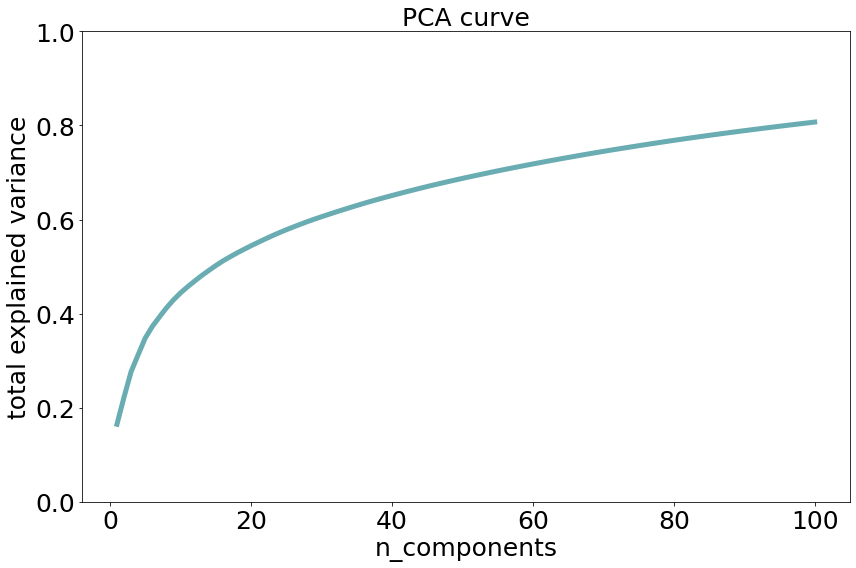

In [25]:
# line chart for pca
variances = [0.16482814061289802, 0.2223819145746536, 0.2763394346424325, 0.3124378899192246, 0.3476828045256034, 0.3724237914978008, 0.3924603433612459, 0.4118063778302636, 0.4289460976761441, 0.4438135520237007, 0.45686272502691594, 0.4689333146119426, 0.48067597048026167, 0.49142755020696366, 0.5019173880117609, 0.5117252158341634, 0.5203731593155279, 0.5287533253106801, 0.536483816913582, 0.5441293845014473, 0.5513279559937098, 0.5584517570543369, 0.5653682922271678, 0.5718891742491293, 0.578127596124597, 0.5841013434611143, 0.5898647034746283, 0.5954800458235158, 0.6007615903598091, 0.6058728049402342, 0.6108481055894086, 0.6157502956846381, 0.620495739344115, 0.6251816450660658, 0.6297958860125071, 0.6342969432937323, 0.6386697447771387, 0.6428558215571614, 0.6469795181867954, 0.6510199321411043, 0.6549824882340276, 0.658880477777978, 0.6626960719755278, 0.6664310328685509, 0.6701428570583742, 0.6737542825885983, 0.6772651594019043, 0.6807256817682505, 0.6841319250625844, 0.6874530878875923, 0.6907297186279356, 0.69394373058717, 0.697148016887181, 0.7002877882119739, 0.7034047198870067, 0.7064476842121273, 0.7094298890127336, 0.712392059176739, 0.7152811745931417, 0.7181568520184315, 0.7210064835951148, 0.7238048811599983, 0.7265681706713947, 0.7292775456304303, 0.7319661264483466, 0.7346181063301133, 0.7372390229848613, 0.7398181203898847, 0.7423728855108283, 0.7448886565566024, 0.7473803731593702, 0.7498073040062887, 0.7522176888451506, 0.7545975002624186, 0.7569607259089246, 0.7592813107633147, 0.7615944768159347, 0.7638732961663743, 0.7661230013792902, 0.768354510871967, 0.7705271473584246, 0.7726805466298771, 0.7747966924502158, 0.7768830974255433, 0.7789506880208489, 0.7810034141596687, 0.7830332830673471, 0.7850291400572543, 0.787000801727109, 0.7889482537267914, 0.7908607886334083, 0.7927534184314946, 0.7946365463823376, 0.7965054348749283, 0.7983463660250288, 0.8001577122572974, 0.8019542733666248, 0.8037231958302018, 0.8054868551526767, 0.8072438590678943]
n_compo = [i for i in range(1,101)]

fig = plt.figure(figsize=(12, 8))

plt.plot(n_compo, variances, color='#69acb2', lw=5)
plt.ylim(0,1)
plt.xlabel('n_components', fontsize=25)
plt.ylabel('total explained variance',fontsize=25)
plt.title('PCA curve',fontsize=25)

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

fig.tight_layout()

plt.savefig('pca_curve.png')
plt.show()